#  Revenue Potential Analysis on Google Play Store Apps

This exploratory data analysis (EDA) project aims to investigate **how app pricing influences installs, ratings, and revenue** on the Google Play Store. 

By estimating potential revenue and analyzing free vs paid apps, pricing strategies, and category-wise earnings, this analysis provides valuable insights for developers, product managers, and marketers looking to optimize app monetization.

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

##  Dataset Overview

- **Source:** Google Play Store Dataset (from Kaggle)
- **Total Apps:** ~10,000+
- **Features Include:**
  - App name, Category
  - Rating, Reviews
  - Installs
  - Price, Type (Free or Paid)
  - Last Updated, Size, Content Rating

Before diving into analysis, we cleaned and transformed key columns (`Price`, `Installs`, etc.) for numeric operations.


In [2]:
# Load Dataset
df = pd.read_csv('googleplaystore.csv')  # Replace with your file path
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [3]:
df.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

##  Data Cleaning

We performed the following steps:

- Removed duplicate app entries
- Dropped rows with missing values in important fields (`Rating`, `Price`, `Installs`)
- Cleaned the `Installs` column (removed '+' and ',' characters and converted to numeric)
- Converted the `Price` column from string to float after removing `$` sign
- Created a new column: `Estimated_Revenue = Price × Installs`

_Note: The revenue estimate is a rough upper-bound and assumes each install corresponds to a full price payment (i.e., no freemium or ads considered)._


In [4]:
# Remove duplicate entries
df.drop_duplicates(inplace=True)

In [5]:
# Drop missing values in key columns
df = df.dropna(subset=['Rating', 'Installs', 'Type', 'Price'])

In [6]:
# Make sure 'Installs' is string first
df['Installs'] = df['Installs'].astype(str)

# Remove '+' and ',' symbols
df['Installs'] = df['Installs'].str.replace('[+,]', '', regex=True)

# Convert to integer safely
df['Installs'] = pd.to_numeric(df['Installs'], errors='coerce')

# Drop NaNs again
df = df.dropna(subset=['Installs'])


##  Free vs Paid Apps Analysis

We compared the performance of free and paid apps based on:

- **Rating distribution**
- **Number of installs**
- **Price range effects**

This helps us understand:
- Do users prefer free apps?
- Are paid apps better rated?
- What's the install gap between free and paid apps?

We used box plots and bar charts to visualize these patterns.


In [7]:
# Step 1: Ensure 'Price' is string first
df['Price'] = df['Price'].astype(str)

# Step 2: Replace 'Free' and remove dollar signs
df['Price'] = df['Price'].replace('Free', '0')
df['Price'] = df['Price'].str.replace('$', '', regex=False)

# Step 3: Convert to float safely
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')  # convert to float, set errors to NaN

# Optional: Drop rows where Price is NaN (invalid or missing data)
df = df.dropna(subset=['Price'])


In [8]:
df['Estimated_Revenue'] = df['Price'] * df['Installs']


In [9]:
# Free vs Paid
df['Type'] = df['Type'].astype('category')


In [10]:
df.groupby('Type')[['Rating', 'Installs', 'Price', 'Estimated_Revenue']].mean()

,Rating,Installs,Price,Estimated_Revenue
Type,,,,
Free,4.182425,1.770223e+07,0.00000,0.000000
Paid,4.261501,1.129078e+05,13.97124,599267.353475


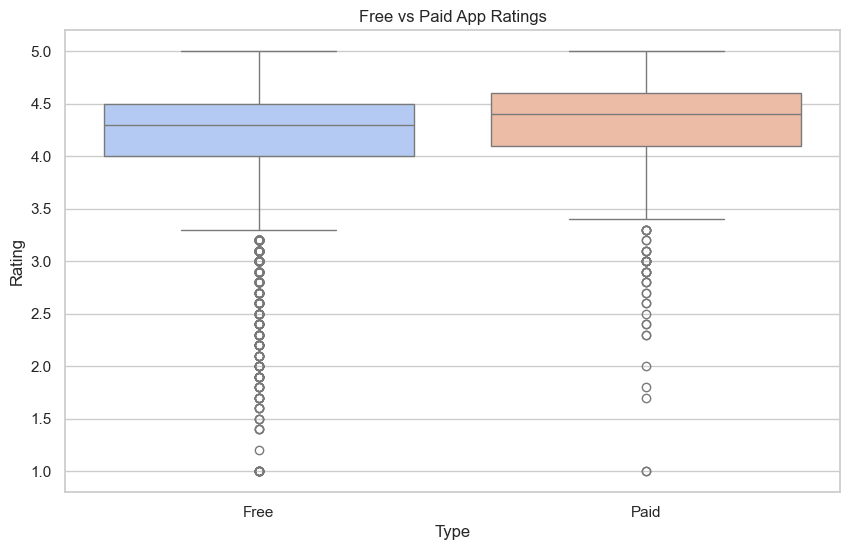

In [11]:
# Visualization - Free vs Paid Apps
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Type', y='Rating', palette="coolwarm")
plt.title('Free vs Paid App Ratings')
plt.show()


##  Revenue Estimation

We introduced a new feature: `Estimated_Revenue = Price × Installs`, giving a rough estimate of an app's potential earnings.

We then:

- Identified the **top 10 revenue-generating paid apps**
- Explored **which price ranges** (e.g., $1-5, $10-50) perform best in terms of installs and ratings
- Analyzed the **distribution of revenue across app categories**


In [12]:
#  Top Revenue Generating Apps
top_revenue_apps = df[df['Type'] == 'Paid'].sort_values(by='Estimated_Revenue', ascending=False).head(10)

fig = px.bar(top_revenue_apps, x='App', y='Estimated_Revenue',
             title='Top 10 Revenue Generating Paid Apps',
             labels={'Estimated_Revenue': 'Estimated Revenue (USD)'},
             color='Estimated_Revenue')
fig.show()


In [13]:
#  Price Optimization Insight
# Which price range performs better?
df['Price_Bin'] = pd.cut(df['Price'], bins=[0, 1, 5, 10, 50, 200],
                         labels=['$0-1', '$1-5', '$5-10', '$10-50', '$50+'])

price_perf = df[df['Type'] == 'Paid'].groupby('Price_Bin')[['Rating', 'Installs']].mean().reset_index()

fig = px.bar(price_perf, x='Price_Bin', y='Installs', title='Avg Installs by Price Range', color='Price_Bin')
fig.show()

In [14]:
fig = px.bar(price_perf, x='Price_Bin', y='Rating', title='Avg Rating by Price Range', color='Price_Bin')
fig.show()


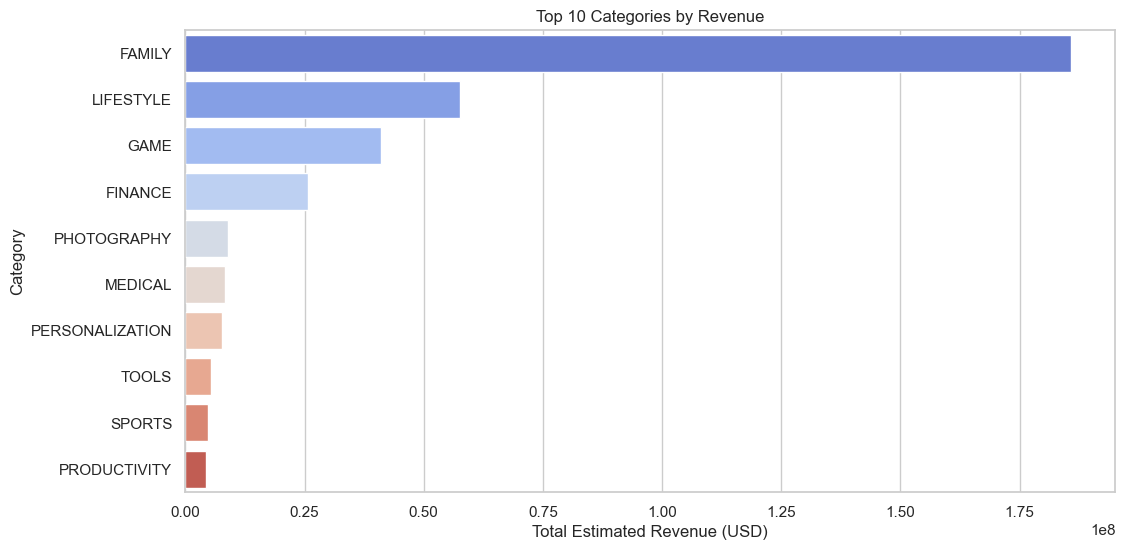

In [15]:
# Category-Wise Revenue Analysis
revenue_by_category = df[df['Type'] == 'Paid'].groupby('Category')['Estimated_Revenue'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=revenue_by_category.values, y=revenue_by_category.index, palette='coolwarm')
plt.title('Top 10 Categories by Revenue')
plt.xlabel('Total Estimated Revenue (USD)')
plt.ylabel('Category')
plt.show()

## Key Insights

- 💸 Most apps are free, but some paid apps still generate significant revenue.
- ⭐ Paid apps tend to have **slightly higher ratings**, possibly due to higher quality expectations.
- 🏆 The **$1–$5 range** showed the best balance between installs and user satisfaction.
- 📱 Categories like **Game, Productivity, and Tools** dominate total estimated revenue.


##  Conclusion

This EDA reveals how pricing strategies and app types affect app performance and potential revenue.

Developers and businesses can use this analysis to:

- Decide whether to go free or paid
- Price their apps competitively
- Target high-revenue categories for development

For future work, deeper modeling (e.g., regression, classification) could predict app success or revenue more accurately.
